# Error Mitigation

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Small Systems of NV center and Surface Electron Spin 

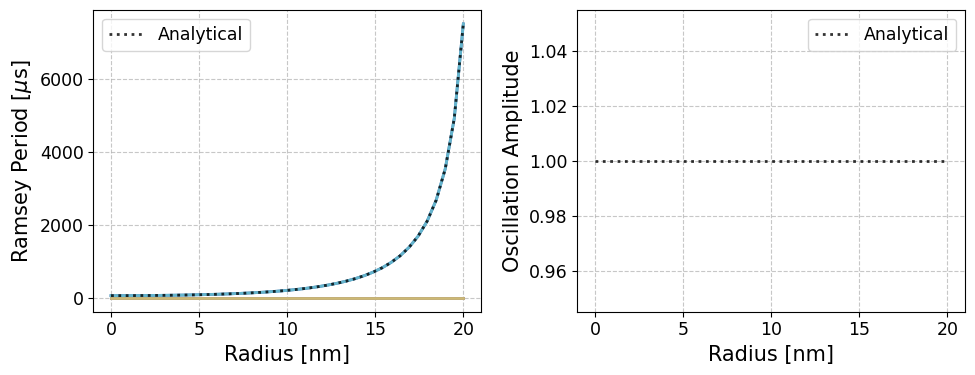

In [165]:
from itertools import combinations

radius_list = np.linspace(0, 20e-9, 40)
periods = np.zeros((6, len(radius_list)))
period_ana = np.zeros(len(radius_list))
amplitude_ana = np.zeros(len(radius_list))

for i, radius in enumerate(radius_list):

    config_spin1 = ('NV0', (0,0,0), 0, {})
    config_spin2 = ('e', (radius, 0e-9, 15e-9), 0, {})
    system = TwoSpinSystem(config_spin1, config_spin2, 0, suter_method=True)
    eigv = system.H.eigenenergies()
    
    for j, (E_i, E_j) in enumerate(combinations(eigv, 2)):
        periods[j][i] = 2*np.pi/abs(E_i - E_j)

    t = 0.5 * ( system.H[0, 0] - system.H[2, 2] + system.H[2, 0] - system.H[0, 2] ).real # Hnew[0,2]
    delta = (system.H[0, 2] + system.H[2, 0]).real # Hnew[0,0] - Hnew[2,2]
    period_ana[i] = 2*np.pi/np.sqrt(delta**2+4*t**2)
    amplitude_ana[i] = 4*t**2/(delta**2+4*t**2)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, period in enumerate(periods):
    ax[0].plot(radius_list * 1e9, period * 1e6)
ax[0].plot(radius_list * 1e9, period_ana * 1e6, 'k:', alpha=0.8, label='Analytical')

# ax.set_ylim(0, 500)
ax[0].set_xlabel(r'Radius [nm]')
ax[0].set_ylabel(r'Ramsey Period [$\mu$s]')
ax[0].legend()

ax[1].plot(radius_list * 1e9, amplitude_ana, 'k:', alpha=0.8, label='Analytical')
ax[1].set_xlabel(r'Radius [nm]')
ax[1].set_ylabel(r'Oscillation Amplitude')
ax[1].legend()
plt.show()

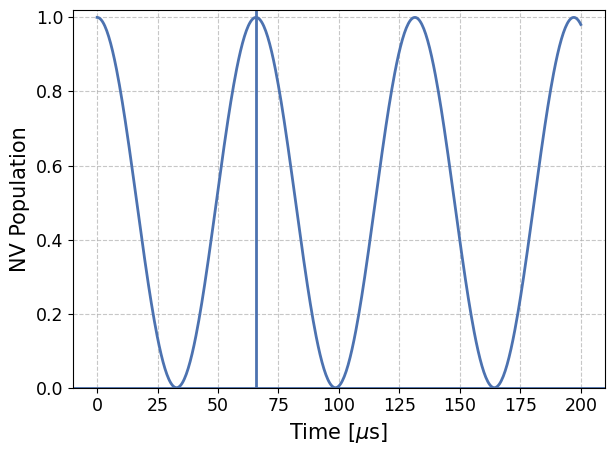

In [157]:
t_list = np.linspace(0, 200e-6, 500)

approx_level = 'gCCE0'
register_config = [('NV0', (0,0,0), 0, {})]
bath_config = [('e', (1e-9, 0e-9, 15e-9), 0, {})]
ham = Hamiltonian(register_config, bath_config, approx_level, verbose=False, suter_method=False)
matrix = 2*np.pi* ham.calc_matrices()[0]

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
# hada = q.tensor(hada, q.qeye(2))
init_state = hada * ham.register_init_state * hada
dms = [(-1j * t * matrix).expm() * init_state * (1j * t * matrix).expm() for t in t_list]

# detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0e-6) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
# detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
# dms = [detuning * dm * detuning.dag() for dm, detuning in zip(dms, detuning_gates)]

dms = [hada * dm * hada for dm in dms]
NV_dms = dms

fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [dm[0,0].real for dm in NV_dms])
ax.set_ylim(0,1.02)
ax.set_ylabel(r'NV Population')
ax.set_xlabel(r'Time [$\mu$s]')

t = 0.5 * ( matrix[0, 0] - matrix[1, 1]).real
delta = 0
ax.axvline(x=2*np.pi/np.sqrt(delta**2+4*t**2) *1e6)
ax.axhline(y=1-4*t**2/(delta**2+4*t**2))
plt.show()

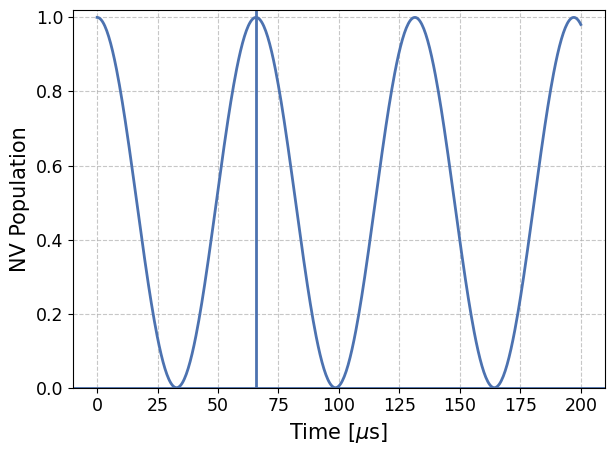

In [160]:
t_list = np.linspace(0, 200e-6, 500)

approx_level = 'gCCE1'
register_config = [('NV0', (0,0,0), 0, {})]
bath_config = [('e', (1e-9, 0e-9, 15e-9), 0, {})]
ham = Hamiltonian(register_config, bath_config, approx_level, verbose=False, suter_method=False)
matrix = 2*np.pi* ham.calc_matrices()[0]

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
hada = q.tensor(hada, q.qeye(2))
init_state = hada * ham.system_init_states[0] * hada
dms = [(-1j * t * matrix).expm() * init_state * (1j * t * matrix).expm() for t in t_list]

# detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0e-6) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
# detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
# dms = [detuning * dm * detuning.dag() for dm, detuning in zip(dms, detuning_gates)]

dms = [hada * dm * hada for dm in dms]
NV_dms = dms

fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [dm[0,0].real for dm in NV_dms])
ax.set_ylim(0,1.02)
ax.set_ylabel(r'NV Population')
ax.set_xlabel(r'Time [$\mu$s]')

t = 0.5 * ( matrix[0, 0] - matrix[2, 2] + matrix[2, 0] - matrix[0, 2] ).real
delta = (matrix[0, 2] + matrix[2, 0]).real
ax.axvline(x=2*np.pi/np.sqrt(delta**2+4*t**2) *1e6)
ax.axhline(y=1-4*t**2/(delta**2+4*t**2))
plt.show()

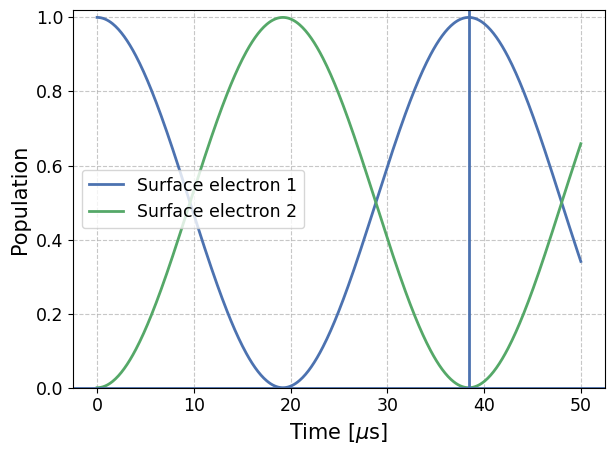

In [164]:
t_list = np.linspace(0, 50e-6, 500)

approx_level = 'no_bath'
register_config = [('e', (0e-9, 0e-9, 15e-9), 0, {}), ('e', (10e-9, 0e-9, 15e-9), 1, {})]
ham = Hamiltonian(register_config, [], approx_level, verbose=False, suter_method=False)
matrix = 2*np.pi* ham.calc_matrices()[0]

dms = [(-1j * t * matrix).expm() * ham.register_init_state * (1j * t * matrix).expm() for t in t_list]
e1_dms = [dm.ptrace(0) for dm in dms]
e2_dms = [dm.ptrace(1) for dm in dms]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [dm[0,0].real for dm in e1_dms], label='Surface electron 1')
ax.plot(t_list*1e6, [dm[0,0].real for dm in e2_dms], label='Surface electron 2')
ax.set_ylim(0,1.02)
ax.set_ylabel(r'Population')
ax.set_xlabel(r'Time [$\mu$s]')
ax.legend()

t = matrix[1, 2].real
delta = 0
ax.axvline(x=2*np.pi/np.sqrt(delta**2+4*t**2) *1e6)
ax.axhline(y=1-4*t**2/(delta**2+4*t**2))
plt.show()

## Surface Electron Spin Bath

In [90]:
# create, save and load a spinbath

spin_type = 'e'
density = 5e-2 / 1e-18 # spins/nm^2
shape = 'circle'
rmin, rmax = 0, 6e-9
num_baths = 2000
num_init_states = 1

directory = os.getcwd()
filename = os.path.join( "baths", "surface_electrons_4")
# filename = os.path.join('baths', 'dominik_bath_small')

# spin_configs, metadata = calc_spin_baths_density(spin_type, density, shape, rmin, rmax, num_baths, num_init_states)
# save_spin_baths(spin_configs, metadata, directory, filename)
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

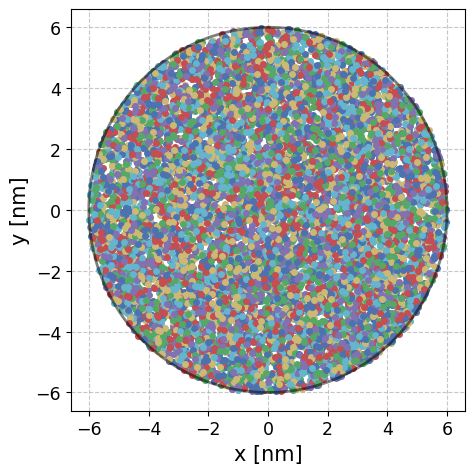

In [91]:
# visualize the spin bath
directory = os.getcwd()
filename = os.path.join( "baths", "surface_electrons_4")
bath_configs_nested, metadata = load_spin_baths(filename, directory, load_metadata=True)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

theta = np.linspace(0, 2 * np.pi, 300) 
x_circle = metadata["rmax"] * np.cos(theta)
y_circle = metadata["rmax"] * np.sin(theta)

fig, ax = plt.subplots(figsize=(5,5))

for bath_config in bath_configs:
    coordinates = np.array(list(zip(*bath_config))[1])
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    ax.plot(x *1e9, y*1e9, '.', markersize=8)
ax.plot(x_circle*1e9, y_circle*1e9, color='k', alpha=0.5, linewidth=2)

ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')
plt.savefig(filename+'.pdf')
plt.show()

## Simulations

### Surface Electron Spins

In [2]:
xp, xm = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
yp, ym = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zp, zm = zp * zp.dag(), zm * zm.dag()

In [4]:
import time

env_approx_level = 'no_bath'

register_config = [('NV', (0, 0, 0), 0, {})]
directory = os.path.join( os.getcwd(), "baths")
filename = "surface_electrons_4"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(suter_method=False, instant_pulses=True, env_approx_level=env_approx_level, verbose=False, thermal_bath=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [80e-6]
t_list = np.linspace(0, 80e-6, 600)

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
start_time = time.time()
init_states = [xm, xp, ym, yp, zm, zp]
new_states_list = []
for init_state in init_states:
    env.old_register_states = [hada * init_state * hada]
    new_states_list.append( env.get_new_register_states(pulse_seq, t_list=t_list) )

for Bz in [0, 5e-6]:
    miri_list = []
    for new_states in new_states_list:
        detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-Bz) / (2*np.pi) - CONST["N_zz"] * CONST["m_N"]
        detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
        
        new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)] 
          
        sigmax = [ q.expect(state, q.sigmax()) for state in new_states ]
        sigmay = [ q.expect(state, q.sigmay()) for state in new_states ]
        sigmaz = [ q.expect(state, q.sigmaz()) for state in new_states ]
        miri_list.append( [sigmax, sigmay, sigmaz] )
    
    miri_list = np.array(miri_list)
    print(f"Shape: {miri_list.shape}")
    
    save_directory = os.path.join(os.getcwd(), "export", filename)
    os.makedirs(save_directory, exist_ok=True)
    save_filename = f"{env.env_approx_level}_{int(Bz*1e6)}uT"
    save_loc = os.path.join(save_directory, save_filename)
    np.save(save_loc, miri_list)
    print(f'Saved as {save_loc}.npy')

Environment approximation level: no_bath
Shape: (6, 3, 600)
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\surface_electrons_4\no_bath_0uT.npy
Shape: (6, 3, 600)
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\surface_electrons_4\no_bath_5uT.npy


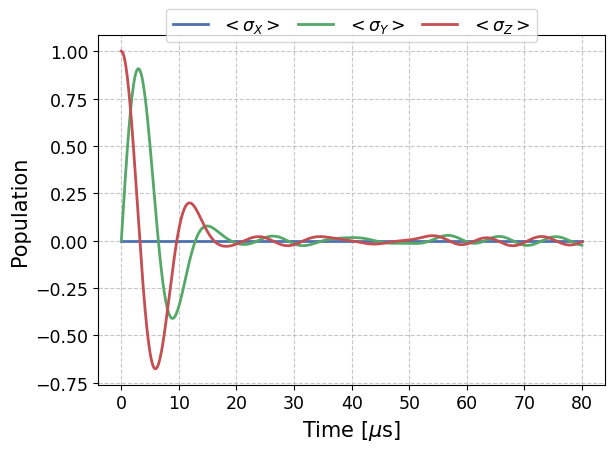

In [105]:
fig, ax = plt.subplots()

save_filename = "Suter\\gCCE0_0uT"
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

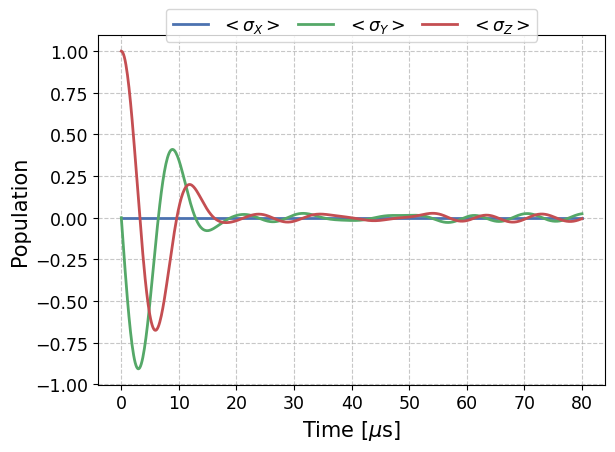

In [106]:
fig, ax = plt.subplots()

save_filename = "Suter\\gCCE1_0uT"
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

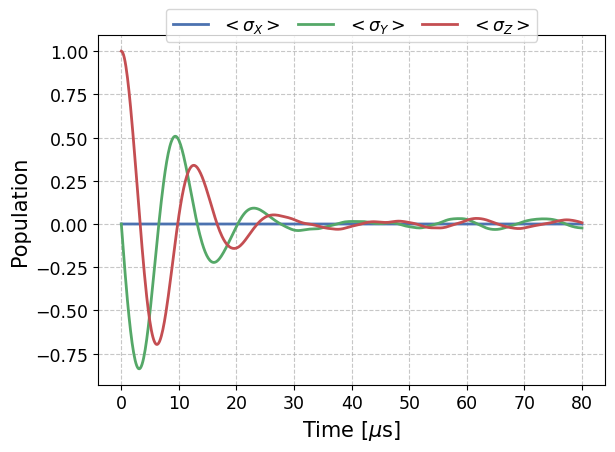

In [107]:
fig, ax = plt.subplots()

save_filename = "Suter\\gCCE2_0uT"
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

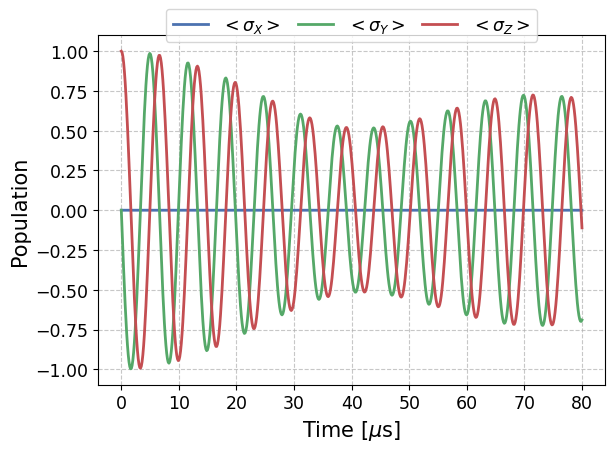

In [87]:
fig, ax = plt.subplots()

save_filename = "noSuter\\full_bath_5uT"
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

Environment approximation level: no_bath


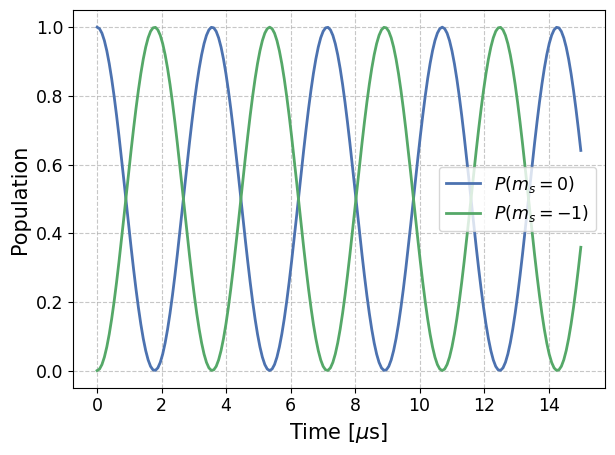

In [6]:
register_config = [('NV', (0, 0, 0), 0, {})]
directory = os.path.join( os.getcwd(), "baths")
filename = "surface_electrons"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='no_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [15e-6]
t_list = np.linspace(0, 15e-6, 200)

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-10e-6) / (2*np.pi) - CONST["N_zz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

### C13 Spin Bath

In [10]:
register_config = [('NV', (0, 0, 0), 0, {})]
directory = os.path.join( os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='no_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 2000)

miri_list = []
init_states = [xm, xp, ym, yp, zm, zp]
for init_state in init_states:
    env.old_register_state = hada * init_state * hada
    
    new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

    detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.0e-4) / (2*np.pi) - CONST["N_zz"] * CONST["m_N"]
    detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
    
    new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)] 
      
    sigmax = [ q.expect(state, q.sigmax()) for state in new_states ]
    sigmay = [ q.expect(state, q.sigmay()) for state in new_states ]
    sigmaz = [ q.expect(state, q.sigmaz()) for state in new_states ]
    miri_list.append( [sigmax, sigmay, sigmaz] )

miri_list = np.array(miri_list)
print(f"Shape: {miri_list.shape}")

save_directory = os.path.join(os.getcwd(), "export", filename)
os.makedirs(save_directory, exist_ok=True)
save_filename = f"{env.env_approx_level}_{int(Bz*1e6)}uT"
save_loc = os.path.join(save_directory, save_filename)
np.save(save_loc, miri_list)
print(f'Saved as {save_loc}.npy')

Environment approximation level: no_bath
Shape: (6, 3, 2000)
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\dominik_bath_small\no_bath_5uT.npy


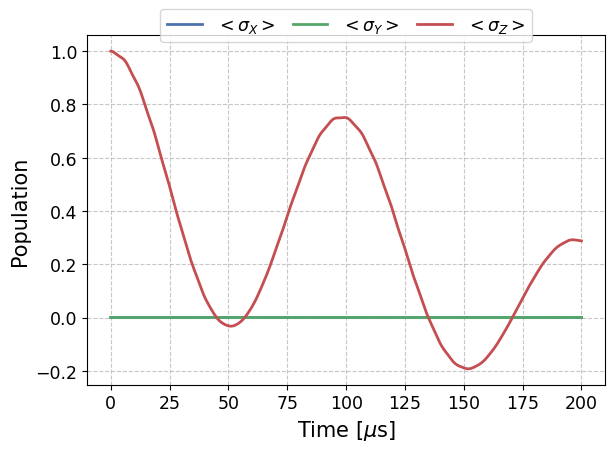

In [184]:
fig, ax = plt.subplots()

save_loc = os.path.join(save_directory, "full_bath")
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

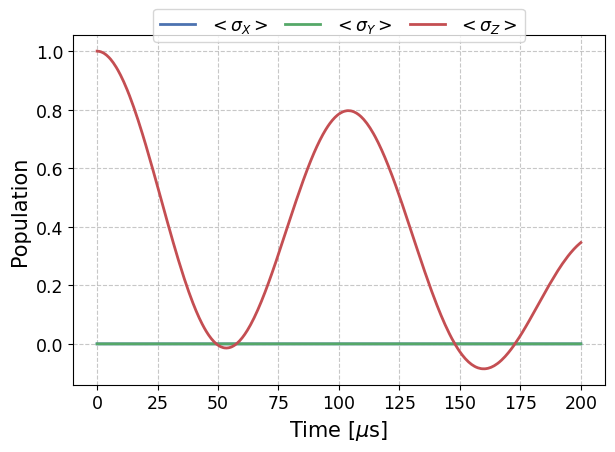

In [182]:
fig, ax = plt.subplots()

save_loc = os.path.join(save_directory, "gCCE1")
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

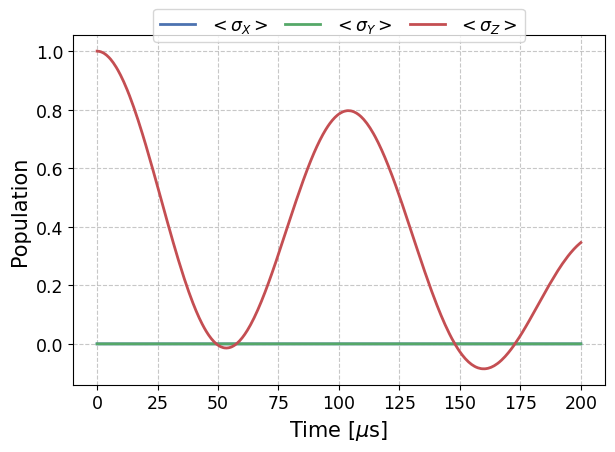

In [189]:
fig, ax = plt.subplots()

save_loc = os.path.join(save_directory, "gCCE0")
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

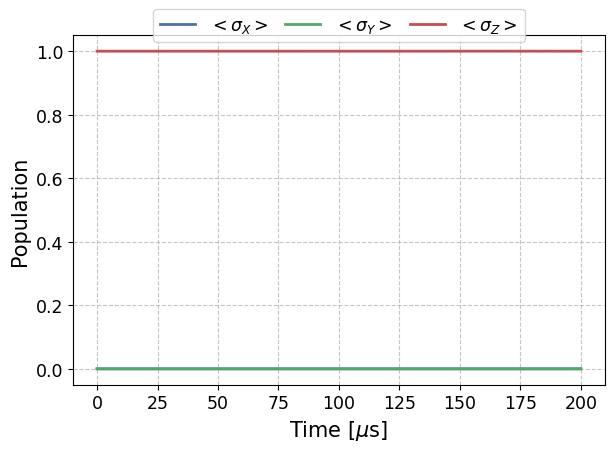

In [188]:
fig, ax = plt.subplots()

save_loc = os.path.join(save_directory, "no_bath")
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

Environment approximation level: no_bath


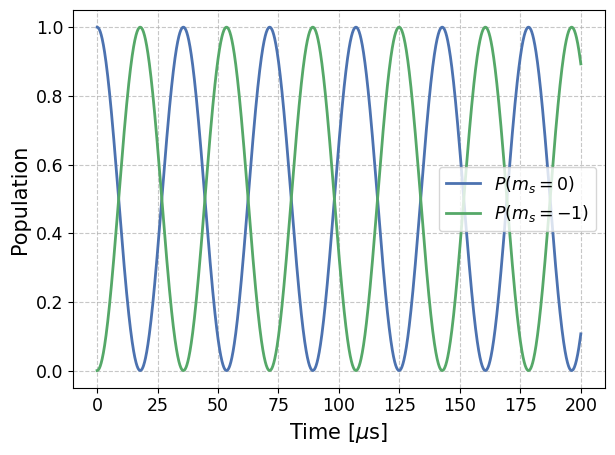

In [7]:
kwargs = dict(suter_method=True, instant_pulses=True, env_approx_level='no_bath', verbose=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

pulse_seq = [200e-6]
t_list = np.linspace(0, 200e-6, 2000)

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
env.old_register_state = hada * zm * hada
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-1e-6) / (2*np.pi) - CONST["N_zz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()